In [2]:
import numpy as np
import matplotlib.pyplot as plt
import additional_code as lib
from skimage.exposure import equalize_hist
%matplotlib inline

import importlib as imp
imp.reload(lib);

# FFT: The algorithm

Rebecca Booth and Nathan Meulenbroek

This notebook will loosely follow our presentation. The intent is to provide the reader with additional information and code to complement the slides, so that you may follow along simultaneously.

## DFT algorithm

**Discrete Fourier Transforms (DFT)** are an extension of Fourier Transforms to the real world, since digital measurements cannot be taken continuously. 

DFTs are order $O(n^2)$ processes i.e. they are very inefficient at large N.

In [6]:
def DFT(x):
    '''
    Takes the DFT using summation.
    
    Params:
        x - (array) vector of values of which to take the DFT
    Returns:
        X - (array) vector of Fourier frequency bins
    '''
    
    # define constants
    i = 0 + 1j
    N = len(x)
    W = np.exp(-2*np.pi*i/N)
    
    # prepare array for DFT of x
    X = np.zeros(N, dtype=np.complex)
    
    for n in range(N):
    # compute the nth value of X 
        
        for k in range(N):
        # sum the k-th value of x * twiddle factor^(n*k)
            Wnk = W**(n*k)
            X[n] += Wnk*x[k]
        
    return X

### Compare results from DFT algorithm to numpy.fft.fft

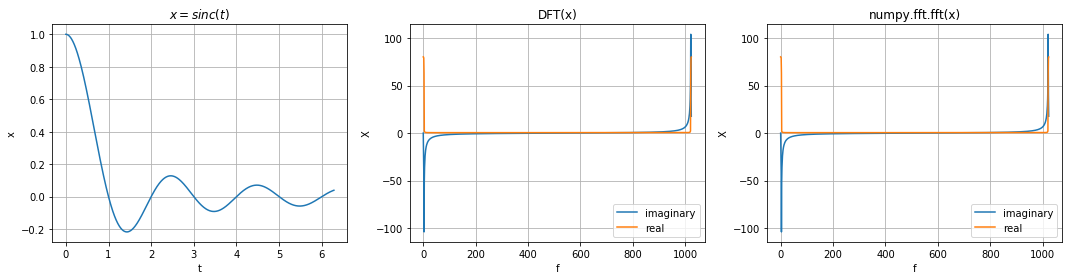

In [7]:
# testing using the sinc function and 2^10 sample points
x = np.linspace(0,2*np.pi,2**10)
y = np.sinc(x)

test_dft = np.array(DFT(y))
test_numpy = np.fft.fft(y)

# -------------------- plotting the results -----------------------
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(x,y)
ax[0].grid('on')
ax[0].set_title('$x=sinc(t)$')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')

ax[1].plot(test_dft.imag, label='imaginary')
ax[1].plot(test_dft.real, label='real')
ax[1].grid('on')
ax[1].set_title('DFT(x)')
ax[1].set_xlabel('f')
ax[1].set_ylabel('X')
ax[1].legend(loc='best')

ax[2].plot(test_numpy.imag, label='imaginary')
ax[2].plot(test_numpy.real, label='real')
ax[2].grid('on')
ax[2].set_title('numpy.fft.fft(x)')
ax[2].set_xlabel('f')
ax[2].set_ylabel('X')
ax[2].legend(loc='best')

plt.tight_layout()

### Compare how long the DFT algorithm takes to the time required by the numpy fft algorithm

In [9]:
%timeit(DFT(y))

1.37 s ± 35.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit(np.fft.fft(y))

42.5 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Fast Fourier Transforms (FFT)

An FFT is a DFT. It is simply a DFT which is highly optimized for computation. The biggest selling feature of an FFT is that it is a much more efficient, order $O(nlog_2n)$ process.

**Important!!! **
For the FFT algorithms described here, make sure that the number of sample points is an integer power of 2.

This notebook will cover the radix-2 algorithm, also known as decimation-in-time, which uses the Dielson-Lanczos lemma to break apart a DFT into two, half size DFTs recursively.

<br/>
<br/>
*The slides will now diverge to discuss the math behind this concept before continuing below*


## FFT recursive algorithm

In [8]:
def fft_recursive(X):
    '''
    Takes the DFT using recursion.
    
    Code taken and modified from external source:
    https://www.reddit.com/r/Python/comments/1la4jp/understanding_the_fft_algorithm_with_python/
    
    Params:
        X - (array) vector of values of which to take the DFT
    Returns:
        X - (array) vector of Fourier frequency bins
    '''

    # this algorithm requires that X is a Python list
    X = list(X)
    
    # store constants
    N = len(X)
    i = 0 + 1j
    W = np.exp(-2*np.pi*i/N)
    
    # continue recursion until the array has been subdivided into length 1
    if N > 1:
        
        # split x into even and odd subarrays
        # pass each subarray back to fft_recursive to continue to be subdivided
        # and then recombine when the results are returned
        X = fft_recursive(X[::2]) + fft_recursive(X[1::2])
        
        # perform the butteryfly calculation
        
        N2 = int(N/2)
        
        for k in range(N2):
            xk = X[k]
            X[k] = xk + W**k*X[k+N2]
            X[k+N2] = xk - W**k*X[k+N2]
    
    return X  

### Compare results from fft recursive algorithm to numpy.fft.fft

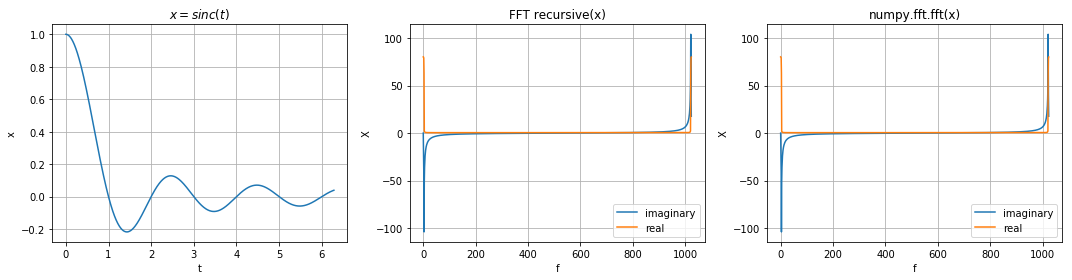

In [9]:
# testing using the sinc function and 2^10 sample points

x = np.linspace(0,2*np.pi,2**10)
y = np.sinc(x)

test = np.array(fft_recursive(y))
test2 = np.fft.fft(y)

# -------------------- plotting the results -----------------------
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(x,y)
ax[0].grid('on')
ax[0].set_title('$x=sinc(t)$')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')


ax[1].plot(test.imag, label='imaginary')
ax[1].plot(test.real, label='real')
ax[1].grid('on')
ax[1].set_title('FFT recursive(x)')
ax[1].set_xlabel('f')
ax[1].set_ylabel('X')
ax[1].legend(loc='best')

ax[2].plot(test2.imag, label='imaginary')
ax[2].plot(test2.real, label='real')
ax[2].grid('on')
ax[2].set_title('numpy.fft.fft(x)')
ax[2].set_xlabel('f')
ax[2].set_ylabel('X')
ax[2].legend(loc='best')

plt.tight_layout()

### Compare how long the FFT recursive algorithm takes to the time required by the numpy fft algorithm

In [15]:
%timeit(fft_recursive(y))

29.3 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit(np.fft.fft(y))

48.1 µs ± 5.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## FFT Iterative (butterfly) algorithm

### Step 1: bit reversal

In [4]:
def bit_reverse(x):
    '''
    A method to bit reverse the order of a list of integers
    
    Params:
        x - (array) list of integers
    Returns:
        y - (array) initial integers in bit reversed order
    '''
    
    N = len(x)
    
    # make sure that the bit reversed array is dtype complex
    y = np.empty(N, dtype = np.complex)
    
    # binary_size = the number of digits in the largest binary number
    binary_size = len(bin(N-1)[2:])
    
    # bit reversal stage
    for n in range(N):
        
        # convert index n to binary, reverse the bit order, 
        # and convert back to a decimal integer
        index = int(bin(n)[2:].zfill(binary_size)[::-1],2)
        
        # store x[n bit reversed] in array element y[n]
        y[n] = x[index]
        
    return y

## Step 2: FFT calculation

In [7]:
def fft_iterative(x, prnt=False):
    '''
    Takes the DFT using iteration.

    Params:
        x - (array) vector of values of which to take the DFT
        prnt - (bool) Optional. Set to true to print out algorihtm progress 
    Returns:
        X - (array) vector of Fourier frequency bins
    '''
    
    # bit reversal stage
    y = bit_reverse(x)
    
    # calculate and store some constants
    i = 0 + 1j 
    N = len(y)
    Nstages = int(np.log2(N))
    
    # ---------------------  loop through stages --------------------------
    for n in range(Nstages): 
        if prnt: print('\n---------------------------------------')
        if prnt: print('stage', n)
        NW = 2**(n+1)
        W = np.exp(-2*np.pi*i/NW)  # W is only calculated once per stage
        
        groups = 2**(Nstages-n-1)  # Calculate the number of groups in this stage
        gr_gap = N//groups         # and the spacing between groups
        
        num_butterflies = 2**n     # Calculate the number of butterflys in this stage
        butterfly_gap = num_butterflies  # and the spacing from the top to the bottom
                                   # of each butterfly
        
        # --------------------- loop through groups -----------------------
        for gr in range (0, groups):
            if prnt: print(' group', gr)
            index = gr * gr_gap   # the index of the first butterfly in group
            
            # -------------------- loop through butterflies ---------------
            for butterfly in range(0, num_butterflies):
                if prnt: print('   butterfly', butterfly, 'top index', butterfly + index, 'bottom index', butterfly + index + butterfly_gap)
                
                # store the value at the top of the current butterfly
                temp_top = y[butterfly + index]            
                
                # store the value at the bottom of the current butterfly
                temp_bottom = y[butterfly + index + butterfly_gap] 
                
                # butterfly calculation
                temp_twiddle = W**butterfly
                y[butterfly + index] = temp_top + (temp_twiddle * temp_bottom)
                y[butterfly + index + butterfly_gap] = temp_top - (temp_twiddle * temp_bottom)
            
    # after all of the stages are complete, y should contain the DFT of x
    return y

### Test with 8 sample points, printing the progress of the algorithm

In [8]:
x = np.linspace(0,2*np.pi,2**3)
test = fft_iterative(x, prnt=True)


---------------------------------------
stage 0
 group 0
   butterfly 0 top index 0 bottom index 1
 group 1
   butterfly 0 top index 2 bottom index 3
 group 2
   butterfly 0 top index 4 bottom index 5
 group 3
   butterfly 0 top index 6 bottom index 7

---------------------------------------
stage 1
 group 0
   butterfly 0 top index 0 bottom index 2
   butterfly 1 top index 1 bottom index 3
 group 1
   butterfly 0 top index 4 bottom index 6
   butterfly 1 top index 5 bottom index 7

---------------------------------------
stage 2
 group 0
   butterfly 0 top index 0 bottom index 4
   butterfly 1 top index 1 bottom index 5
   butterfly 2 top index 2 bottom index 6
   butterfly 3 top index 3 bottom index 7


### Compare results from fft iterative algorithm to numpy.fft.fft

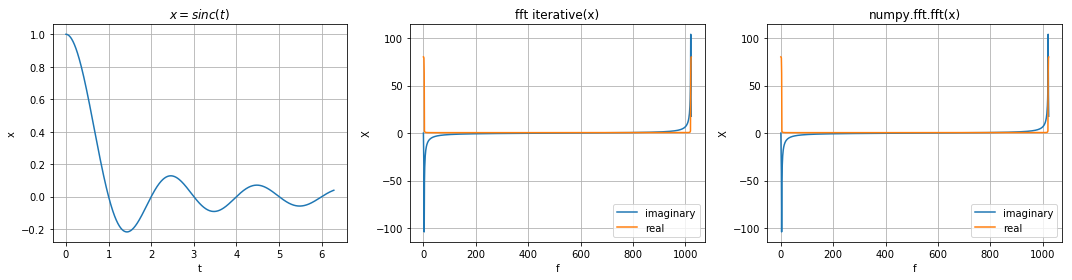

In [23]:
# testing using the sinc function and 2^10 sample points

x = np.linspace(0,2*np.pi,2**10)
y = np.sinc(x)

test = np.array(fft_iterative(y))
test2 = np.fft.fft(y)

# -------------------- plotting the results -----------------------
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].plot(x,y)
ax[0].grid('on')
ax[0].set_title('$x=sinc(t)$')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')

ax[1].plot(test.imag, label='imaginary')
ax[1].plot(test.real, label='real')
ax[1].grid('on')
ax[1].set_title('fft iterative(x)')
ax[1].set_xlabel('f')
ax[1].set_ylabel('X')
ax[1].legend(loc='best')

ax[2].plot(test2.imag, label='imaginary')
ax[2].plot(test2.real, label='real')
ax[2].grid('on')
ax[2].set_title('numpy.fft.fft(x)')
ax[2].set_xlabel('f')
ax[2].set_ylabel('X')
ax[2].legend(loc='best')

plt.tight_layout()

### Compare how long the FFT iterative algorithm takes to the time required by the numpy fft algorithm

In [21]:
%timeit(fft_iterative(y))

14 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit(np.fft.fft(y))

39.4 µs ± 314 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


These algorithms are now using extremely similar methods of calculating the DFT. The main difference here is in memory managment and small loop optimisations which are only possible in the underlying FORTRAN code. If you are interested in more of how they squeak out these little performance upgrades, a good resource can be found at: http://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

## Applications: Computerised Tomography

In brief, **Computerized tomography** scans are commonly used in medicine as a non-invasive method of looking into the body. Unlike x-rays, a CT scan doesn't just show shadows of dense materials such as bones, CT scans can show soft tissue structures such as like organs and tumours. Another application of computerized tomography can be found in Earth science, where seismic waves are used to image structures inside the surface of our planet.

In tomography, a wave is passed through the object being imaged along a cross sectional line called an image slice and the change in intensity of the wave is measured as it exits the slice. Since it is the internal structures of the object that change the intensity of the wave, it is possible to work backwards and use this change in intensity to learn something about these structures. Image slices are taken through the object at a large number of angles and offsets and through the combination of these image slices, a reconstruction of a cross section of the object can be produced.

For the purposes of this example, we use a Shepp-Logan phantom as our imaged object. The Shepp-Logan phantom is defined as the superposition of ten different ellipses which are slightly offset in density values. This is meant to represent the difference in attenuation provided by different types of tissue in the human body. Since the values are offset by 1-2% of each other in some cases, the contrast between the ellipses will be quite weak when unnormalised.

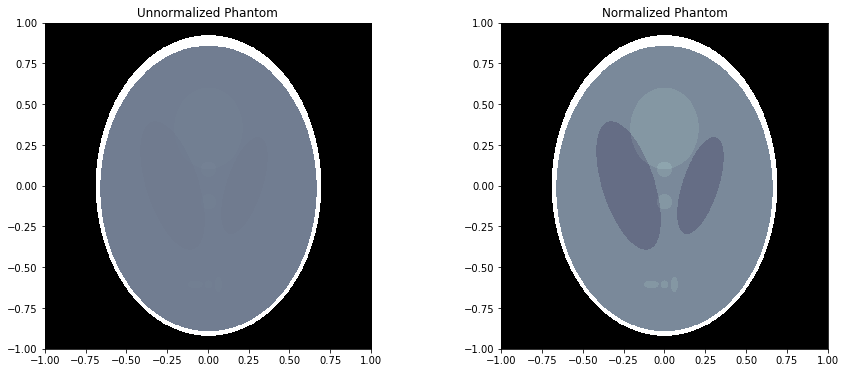

In [19]:
nx, ny = 999,1001
xx, yy = np.meshgrid(np.linspace(-1.0,+1.0,nx), np.linspace(-1.0,+1.0,ny) )
phantom = lib.shepp_logan_phantom(xx, yy)

fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].imshow((phantom), origin='0', extent=(-1, 1, -1, 1))
ax[0].set_title("Unnormalized Phantom")

ax[1].imshow(equalize_hist(phantom, nbins=10), origin='0', extent=(-1, 1, -1, 1))
ax[1].set_title("Normalized Phantom");

The sinogram is essentially a stack of all of these scan lines for different angles. A scan line is the attenuation of a discrete beam being shot through the medium or object.

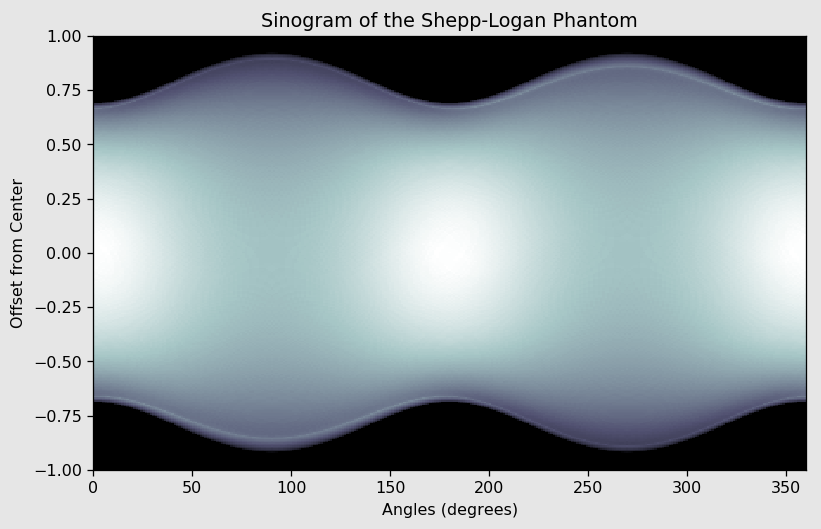

In [20]:
nx, ny = 299, 301
offset_xprime, angle_phi = np.array([1]), np.linspace(0,2.0*np.pi,ny) 
sinogram = lib.sinogram(offset_xprime, angle_phi, nx=nx, ny=ny, full_set=True)

#**********Plotting**********
lib.make_plot(title='Sinogram of the Shepp-Logan Phantom', 
              x_label='Angles (degrees)', y_label='Offset from Center', 
              grid=False)
plt.imshow(sinogram, origin='0', extent=(0, 360, -1, 1), aspect='auto')
plt.set_cmap('bone')
plt.show()

Code for the back projection algorithm, and all algorithms in this section, can be found in the accompanying document in this folder or in the slides.

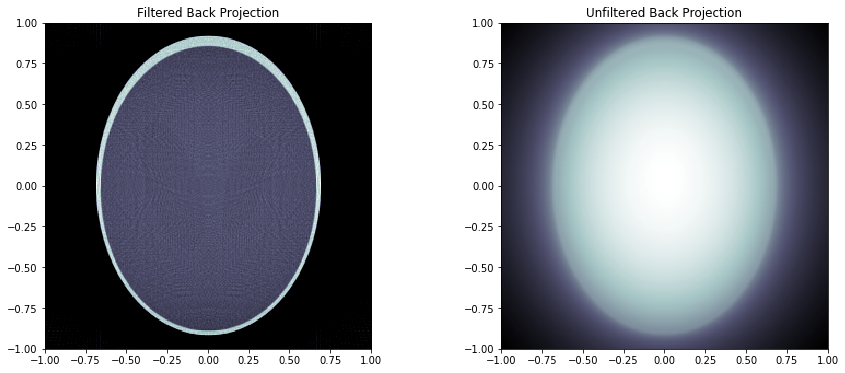

In [27]:
back_projected_reconstruction = lib.backprojection(sinogram, angle_phi)
back_projected_unfiltered = lib.backprojection(sinogram, angle_phi, filtered=False)

#**********Plotting**********
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].imshow(back_projected_reconstruction, origin='0', extent=(-1, 1, -1, 1))
ax[0].set_title("Filtered Back Projection")

ax[1].imshow(back_projected_unfiltered, origin='0', extent=(-1, 1, -1, 1))
ax[1].set_title("Unfiltered Back Projection");

As one can see here, the difference is quite drastic. Purely anecdotal evidence also shows that the back projection is efficient in reconstructing these images.